# Transfer Learning on American Sign Language

In [2]:
# set the python env so that we can use the project utils
import sys
sys.path.append("/home/studio-lab-user/sign-language-image-detection")

import tensorflow as tf
from pprint import pprint
from tqdm import tqdm
import matplotlib.pyplot as plt

import src.utils.keras_dataset_utils as keras_dataset_utils

2025-01-11 17:43:16.588554: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
!pip install seaborn

import seaborn as sns

## Load Dataset

The dataset is structured into folders. Each folder has the name of the `label` and contains all relevant `images` of this label.

Train and Test set are also found into two separate folders.

This allows us to use the `image_dataset_from_directory` method from keras to quickly load the datase.

We __normalize__ the dataset and split it into:

- train set
- validation set (15% of the train set)
- test set


In [4]:
# A quick check to find the dimentionality of the images
from PIL import Image

img = Image.open("/home/studio-lab-user/sign-language-image-detection/sign_datasets/american_sign_language_dataset/ASL_Dataset/Train/A/1047.jpg")

print(f'Image dimentions: {img.size}')

Image dimentions: (400, 400)


In [6]:
dataset_path = "/home/studio-lab-user/sign-language-image-detection/sign_datasets/american_sign_language_dataset/ASL_Dataset/Train/"

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=(400, 400),
    batch_size=64,
    shuffle=True
)

# The test dataset is under the test folder
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path.replace("/Train/", "/Test/"),
    image_size=(400, 400),
    batch_size=64,
    shuffle=True
)

def normalize_image(image, label):
    # TODO: Calculate mean, std for the images
    precomputed_mean = [0.52732987, 0.4507709, 0.41209071]
    precomputed_std = [0.19798545, 0.23537221, 0.26049182]

    # Normalize the image
    image = (image / 255.0 - precomputed_mean) / precomputed_std
    return image, label

# Split the train into train and validation
train_size = int(0.85 * len(dataset))

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# TODO: Apply normalization

# Set performance settings
# Prefetch one batch at a time
buffer_size = 1
train_dataset = train_dataset.prefetch(buffer_size=buffer_size)
val_dataset = val_dataset.prefetch(buffer_size=buffer_size)
test_dataset = test_dataset.prefetch(buffer_size=buffer_size)


Found 165670 files belonging to 28 classes.
Found 112 files belonging to 28 classes.


## Visualizations

Bellow we can see some visualizations for this dataset

100%|██████████| 2200/2200 [03:19<00:00, 11.04it/s]


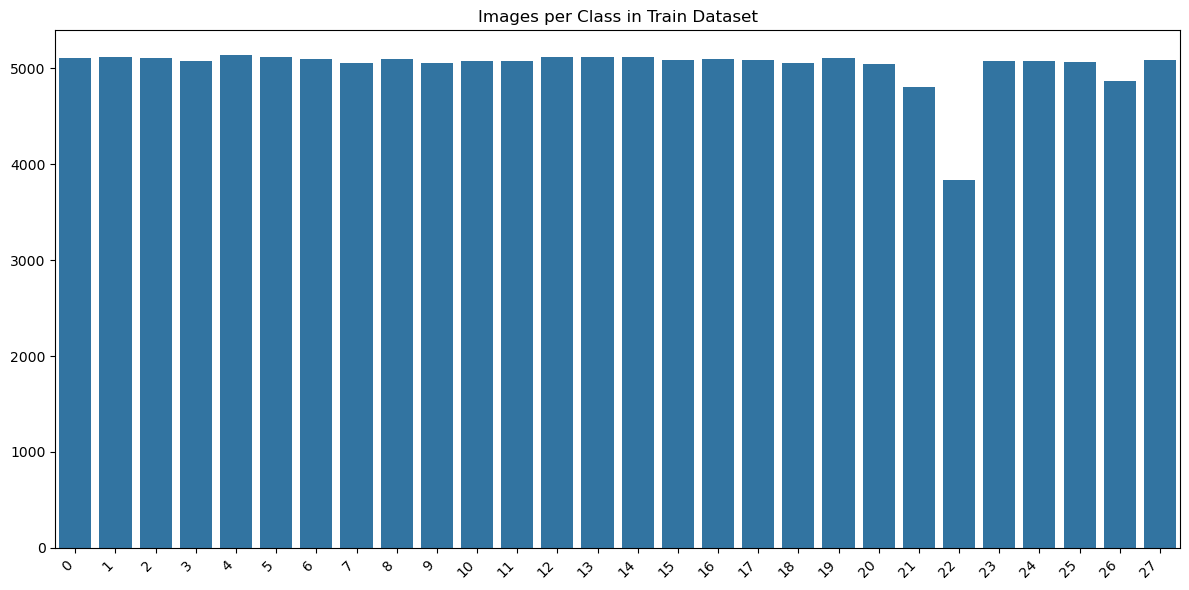

In [7]:
keras_dataset_utils.plot_class_distribution(train_dataset, "Images per Class in Train Dataset")

100%|██████████| 389/389 [03:16<00:00,  1.98it/s]  


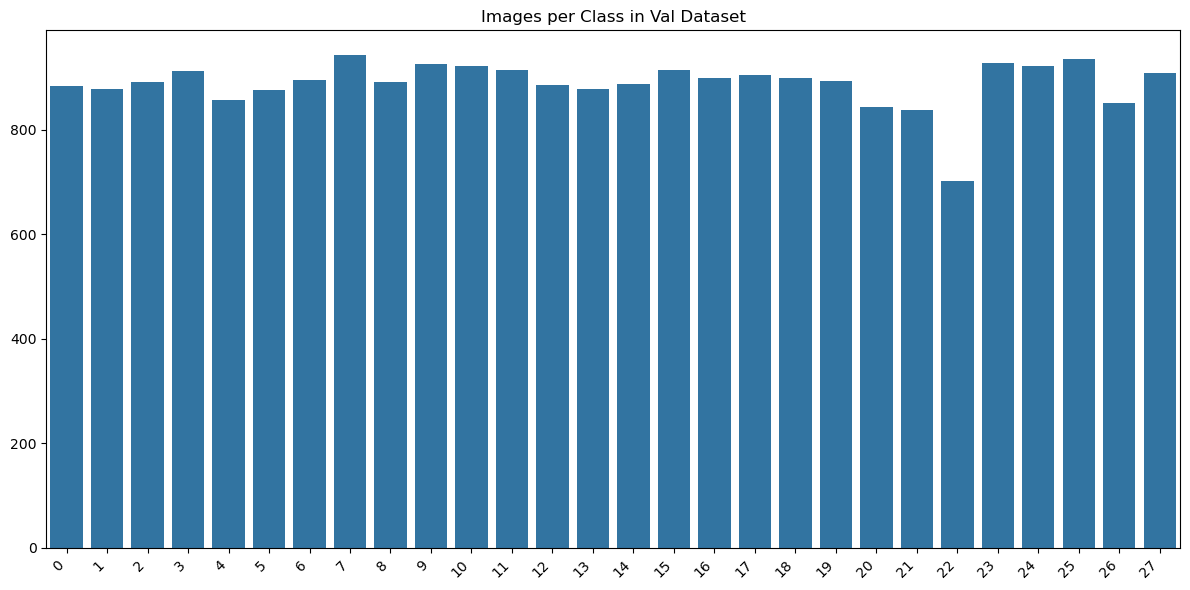

In [9]:
keras_dataset_utils.plot_class_distribution(val_dataset, "Images per Class in Val Dataset")

100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


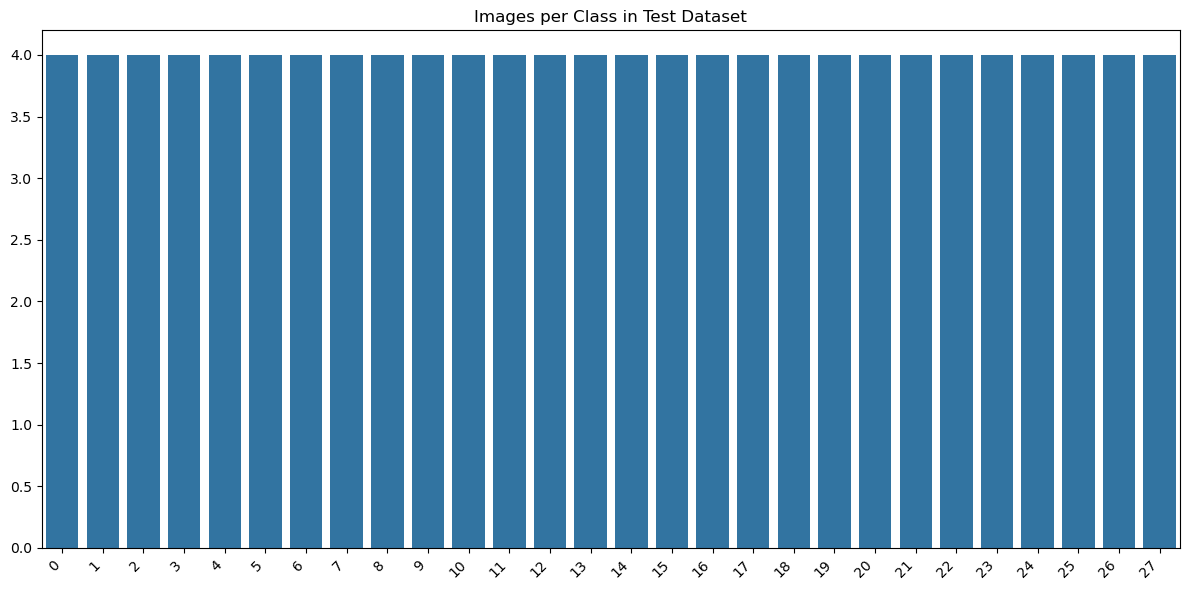

In [10]:
keras_dataset_utils.plot_class_distribution(test_dataset, "Images per Class in Test Dataset")

## MobileNet Transfer Learning

Let's try to finetune `MobileNetV2` for our task.

MobileNetV2 is trained on the `imagenet` dataset.

Due to the fact that it works with some specific image sizes, we have to reshape our images from (400, 400) to (?????)